### PART 1: NAIVE METHOD

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_submission_csv(X, filename):
    N = len(submission_item_idx)
    array_sub = np.zeros(N)
    df_sub = df_sample_submission.copy()

    for k in range(N):
        i = item_indices[k]
        j = user_indices[k]
        array_sub[k] = X[i,j]

    df_sub.Prediction = array_sub
    df_sub.to_csv(filename + '.csv', index=False)
    print('Exported ' + filename + '.csv')

In [3]:
X_train = pd.read_csv('data_train.csv')
m_train, n_train = X_train.shape

X_pred = pd.read_csv('sampleSubmission.csv')
m_pred, n_pred = X_pred.shape

In [4]:
X_pred.shape

(1176952, 2)

In [3]:
# Make a new DF with the missing user/item indices
X_pred2 = pd.DataFrame.copy(X_pred)

# Insert the item ids as a separate column
X_pred2['Item'] = X_pred2.Id.str.split('_', expand=True)[1]

In [4]:
# Make a new DF with the item id in a separate column
items_train = pd.DataFrame.copy(X_train)
items_train.Id = (items_train.Id.str.split('_', expand=True))[1]

In [5]:
# Calculate the item means
item_means = items_train.groupby('Id').mean().round().astype(int)

# Extract the items and their corresponding scores
items = list(item_means.index)
mean_scores = list(item_means.Prediction)

In [86]:
# Insert the average score for each item in the X_pred2 DataFrame
# This takes a few minutes to run...
for i, item in enumerate(items):
    X_pred2.loc[X_pred2.Item == item, 'Prediction'] = mean_scores[i]

In [107]:
# Export to CSV
export = pd.DataFrame.copy(X_pred2)

# Drop the Item column
export = export.drop('Item', axis=1)
export.to_csv('part1.csv', index=False)

In [83]:
# Compute MSE, comparing the the Sample Submission data set (Not ground truth)
((X_pred2.Prediction - X_pred.Prediction)**2).mean()

0.0

### PART 2: Using SVD

2.1: Transforming the data to a matrix of users $\times$ items

In [7]:
# Item means using floating point precision
item_means_float = items_train.groupby('Id').mean()

In [8]:
item_means_float.to_csv('item_means_float.csv')

In [9]:
X_all = pd.read_csv('X_all.csv')
X_users = X_all.User.unique()
X_items = X_all.Item.unique()

In [10]:
# Items (row) x Users (cols) ∈ R{1,000 x 10,000}
X = X = np.loadtxt('X_full_float.txt')
m,n = X.shape
print('X:', m, 'x', n)

X: 1000 x 10000


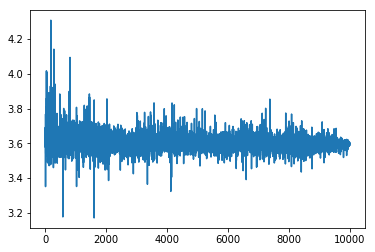

In [11]:
m0 = X.mean(axis=0)
plt.plot(range(len(m0)), m0)
plt.show()

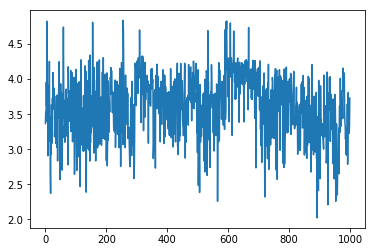

In [12]:
m1 = X.mean(axis=1)
plt.plot(range(len(m1)), m1)
plt.show()

In [130]:
# Perform Singular Value Decomp.
U,s,VT = np.linalg.svd(X, full_matrices=True)

In [131]:
# Diagonalize S
S = np.zeros((m,n))
S[:min(m,n), :min(m,n)] = np.diag(s)

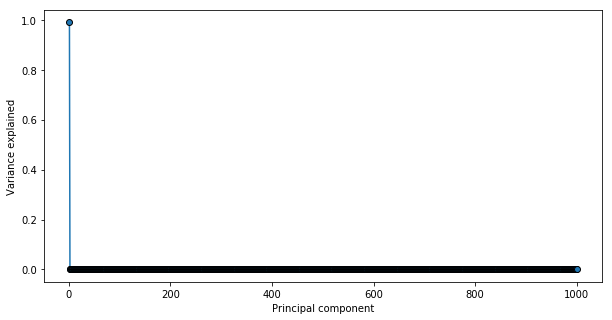

In [15]:
# Explained variance
var = s**2 / np.sum(s**2)
xaxis = np.arange(1, var.size + 1)

# Plot variance explained
plt.figure(figsize=[10,5])
plt.plot(xaxis, var, "o-", markeredgecolor="black")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.show()

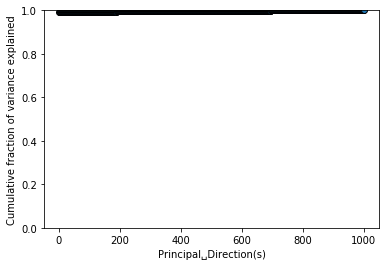

In [16]:
cumulative = np.cumsum(var)
plt.plot(xaxis, cumulative , "o-", markeredgecolor="black") 
plt.xlabel("Principal␣Direction(s)") 
plt.ylabel("Cumulative fraction of variance explained")
plt.ylim([0,1])
plt.show()

In [136]:
k = 1
X_approx = U[:,:k]@S[:k, :k]@VT[:k, :]

In [124]:
X_approx.shape

(1000, 10000)

In [277]:
# Average difference per entry
np.sqrt((X_approx - X)**2).mean()

0.1470753267926223

In [278]:
X_pred3 = pd.DataFrame.copy(X_pred2)
users = (X_pred3.Id.str.split('_', expand=True))[0]
X_pred3['User'] = users

In [ ]:
extract_submission_csv(X_approx, 'sqrt_k=1')

#### Using SQRT

In [132]:
# For simplicity use sqrt
k = 1
D_ = np.sqrt(S)[:k, :k]
U_ = U[:, :k] @ D_
VT_ = D_ @ VT[:k, :]

In [133]:
X_approx_sqrt = (U_ @ VT_)

# RMSE
rmse_x_approx = np.sqrt((X_approx - X)**2).mean()

# RMSE with sqrt method
rmse_x_approx_sqrt = np.sqrt((X_approx_sqrt - X)**2).mean()

print(rmse_x_approx - rmse_x_approx_sqrt)

376.92029859307354


In [138]:
X_approx_sqrt

array([[3.40940162, 3.44575579, 3.34297549, ..., 3.36607788, 3.37298349,
        3.35536426],
       [3.57095193, 3.6090287 , 3.50137828, ..., 3.52557536, 3.53280818,
        3.51435408],
       [3.48400137, 3.52115099, 3.41612179, ..., 3.43972968, 3.44678639,
        3.42878164],
       ...,
       [3.26886394, 3.30371957, 3.20517593, ..., 3.22732603, 3.23394699,
        3.21705403],
       [3.37136876, 3.40731739, 3.30568363, ..., 3.32852831, 3.33535688,
        3.3179342 ],
       [3.77601725, 3.81628062, 3.70244827, ..., 3.72803488, 3.73568306,
        3.71616921]])

In [139]:
extract_submission_csv(X_approx_sqrt, 'sqrt_k=1')

Exported sqrt_k=1.csv


### Gradient Descent

In [ ]:
path = ''
item_indices = np.loadtxt(path + 'item_indices_all.txt').astype(int)
user_indices = np.loadtxt(path + 'user_indices_all.txt').astype(int)
X_sparse = np.loadtxt(path + 'X_sparse.txt')

In [84]:
def gradient_descent(X, user_idx, item_idx, alpha=0.001, epochs=10, k=10):
    '''
    *** From: http://nicolas-hug.com/blog/matrix_facto_4
    A:      Data Matrix           [m x n]
    alpha:  Learning rate         [scalar]
    epochs: Number of iterations  [scalar]
    k:      dimensions to use     [int]
    m:      items
    n:      users
    '''
    m,n = X.shape
    # U: Item dim, V: User dim
    U = np.random.normal(0, .1, (m, k)).astype(np.float64)
    V = np.random.normal(0, .1, (n, k)).astype(np.float64)
    
    for e in range(epochs):
        for idx in range(len(item_idx)):
            i,j = item_idx[idx], user_idx[idx]
            err = X[i,j] - np.dot(U[i], V[j].T)
            U[i] += alpha * err * V[j]
            V[j] += alpha * err * U[i]
        print('Finished iteration %i of %i' % (e+1, epochs))
    return U,V

In [116]:
def sgd(X, user_idx, item_idx, alpha=0.001, epochs=10, k=10):
    '''
    *** From: http://nicolas-hug.com/blog/matrix_facto_4
    A:      Data Matrix           [m x n]
    alpha:  Learning rate         [scalar]
    epochs: Number of iterations  [scalar]
    k:      dimensions to use     [int]
    m:      items
    n:      users
    '''
    m,n = X.shape
    U = np.random.normal(0, .1, (m, k)).astype(np.float64)
    Z = np.random.normal(0, .1, (n, k)).astype(np.float64)
    indices = np.arange(len(item_idx))
    err_history = np.zeros(epochs)
    
    for e in range(epochs):
        # Shuffle indices every epoch (Stochastic step)
        np.random.shuffle(indices)
        for idx in indices:
            i,j = item_idx[idx], user_idx[idx]
            err = X[i,j] - np.dot(U[i], Z[j].T)
            U[i] += alpha * err * Z[j]
            Z[j] += alpha * err * U[i]
            # Save error value for later analysis
            err_history[e] = err
        print('Finished iteration %i of %i' % (e+1, epochs))
    return U, Z, err_history

In [178]:
np.ones((1,2)) * 2.5

array([[2.5, 2.5]])

In [176]:
np.random.normal(2.5, 1, (1,2))

array([[3.82768823, 1.46194895]])

In [180]:
def sgd(X, user_idx, item_idx, alpha=0.001, epochs=10, k=10):
    '''
    *** From: http://nicolas-hug.com/blog/matrix_facto_4
    A:      Data Matrix           [m x n]
    alpha:  Learning rate         [scalar]
    epochs: Number of iterations  [scalar]
    k:      dimensions to use     [int]
    m:      items
    n:      users
    '''
    mean_score = 3
    m,n = X.shape
    U = np.ones((m, k)).astype(np.float64) * mean_score
    Z = np.ones((k, n)).astype(np.float64) * mean_score
    indices = np.arange(len(item_idx))
    err_history = np.zeros(epochs)
    
    for e in range(epochs):
        # Shuffle indices every epoch (Stochastic step)
        np.random.shuffle(indices)
        for idx in indices:
            i, j = item_idx[idx], user_idx[idx]
            err = X[i,j] - np.dot(U[i], Z[:, j])
            U[i] += alpha * err * Z[:, j]
            Z[:, j] += alpha * err * U[i]
            # Save error value for later analysis
            err_history[e] = err
        print('Finished iteration %i of %i' % (e+1, epochs))
    return U, Z, err_history

In [181]:
U, Z, err_history = sgd(X_sparse, user_indices, item_indices, epochs=20, k=5)

KeyboardInterrupt: 

In [151]:
X_hat = U@Z
X_hat

array([[2.98554008, 3.10485022, 2.76208712, ..., 2.1475899 , 2.40683259,
        2.0700478 ],
       [3.75793867, 3.9081159 , 3.47667547, ..., 2.70319972, 3.02951191,
        2.60559646],
       [3.29360028, 3.42522132, 3.04709053, ..., 2.36918698, 2.65517939,
        2.28364377],
       ...,
       [3.07747904, 3.2004633 , 2.8471449 , ..., 2.21372439, 2.4809504 ,
        2.1337944 ],
       [3.22573286, 3.35464174, 2.98430265, ..., 2.32036788, 2.60046717,
        2.23658736],
       [3.93673475, 4.09405716, 3.64208955, ..., 2.83181319, 3.17365074,
        2.72956614]])

In [153]:
extract_submission_csv(X_hat, 'sgd_5_float')

Exported sgd_5_float.csv


In [143]:
U,V = gradient_descent(X_sparse, user_indices, item_indices)

KeyboardInterrupt: 

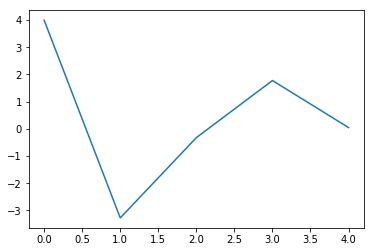

In [152]:
import matplotlib.pyplot as plt
plt.plot(err_history)
plt.show()

In [111]:
X_hat_round = X_hat.round()

In [113]:
extract_submission_csv(X_hat, 'sgd_5_float')

Exported sgd_6_round.csv
